In [1]:
#do what the keras people suggest

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('demo_style.mplstyle')

#tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
#get job info

import os

os.environ["SLURM_JOB_ID"]

'769744'

In [3]:
q003_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_data.npy')
#q003_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_max.npy')
#q003_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_norm.npy')

q103_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_data.npy') 
#q103_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_max.npy')
#q103_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_norm.npy')

In [4]:
#downsample for now

n=10 #

print(q003_data.shape)
print(q103_data.shape)

#use the normalized data!

q003_data = q003_data[0::n,:,:]
q103_data = q103_data[0::n,:,:]

print(q003_data.shape)
print(q103_data.shape)

(3151, 625, 512)
(6636, 625, 512)
(316, 625, 512)
(664, 625, 512)


In [5]:
#cut to make square for later autoencoder friendly size

q003_data = q003_data[:,0:512,:]
q103_data = q103_data[:,0:512,:]


In [6]:
#we shuffle in the training so it's ok
qall_data = np.concatenate((q003_data, q103_data), axis=0)

print(qall_data.shape)

#shuffle by default
x_train, x_test = train_test_split(qall_data, random_state=42) 
print(x_train.shape)
print(x_test.shape)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)
print(x_test.shape)

##can we memorize a single image
#x_train = x_train[0:1,:]
##train and test on the same image?
#x_test = x_train


(980, 512, 512)
(735, 512, 512)
(245, 512, 512)
(735, 512, 512, 1)
(245, 512, 512, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

latent_dim = 8

H=512
W=512
C=1

inputs = Input(shape=(H, W, C), name="inputs")
x = inputs

#encoder
x = Conv2D(32, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(32, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(16, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(16, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(8, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(8, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(8, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)


#this is the latent layer
x = Flatten()(x)
units = x.shape[1]
x = Dense(latent_dim, name="latent")(x)
x = Dense(units)(x)
x = LeakyReLU(alpha=0.2)(x)

#encoded data

#decoder

#first reshape to undo flatten
x = Reshape((4,4,8))(x)

x = Conv2DTranspose(8, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(8, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(4, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(4, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(2, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(2, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(1, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("sigmoid", name="outputs")(x)

outputs = x

    
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')
autoencoder.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0     

In [8]:

# This function keeps the learning rate at 0.001 for the first ten epochs
# and decreases it exponentially after that.

#aim for 1e-8 at final epoch
#start with 1e-3 
#every x epochs half the learning rate

numepochs= 5

def scheduler(epoch):
    if epoch < 30:
        print("learning rate: {}".format(0.001))
        return 0.001
    else:
        print("learning rate: {}".format(0.001 * tf.math.exp(0.05 * (20 - epoch))))
        return 0.001 * tf.math.exp(0.05 * (20 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)        

history = autoencoder.fit(x_train, x_train,
                epochs=numepochs,
                batch_size=64,
                validation_data=(x_test, x_test),
                shuffle=True, 
                verbose=1,
                callbacks=[callback])

print('\nhistory dict:', history.history)



autoencoder.save('conv2d_autoencoder')




Train on 735 samples, validate on 245 samples
learning rate: 0.001
Epoch 1/5
735/735 [==============================] - 15s 20ms/sample - loss: 0.7581 - val_loss: 0.6819
learning rate: 0.001
Epoch 2/5
735/735 [==============================] - 3s 5ms/sample - loss: 0.7213 - val_loss: 0.6719
learning rate: 0.001
Epoch 3/5
735/735 [==============================] - 3s 5ms/sample - loss: 0.7056 - val_loss: 0.6662
learning rate: 0.001
Epoch 4/5
735/735 [==============================] - 3s 5ms/sample - loss: 0.6948 - val_loss: 0.6614
learning rate: 0.001
Epoch 5/5
735/735 [==============================] - 3s 4ms/sample - loss: 0.6807 - val_loss: 0.6582

history dict: {'loss': [0.7581203781017641, 0.721253080027444, 0.7056296155566261, 0.6947874113005035, 0.6806842404968885], 'val_loss': [0.6819208524665054, 0.6718625024873384, 0.6661831870370981, 0.6614184518249667, 0.6582450421489014], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}
Instructions for updating:
If using Keras pass *_constraint 

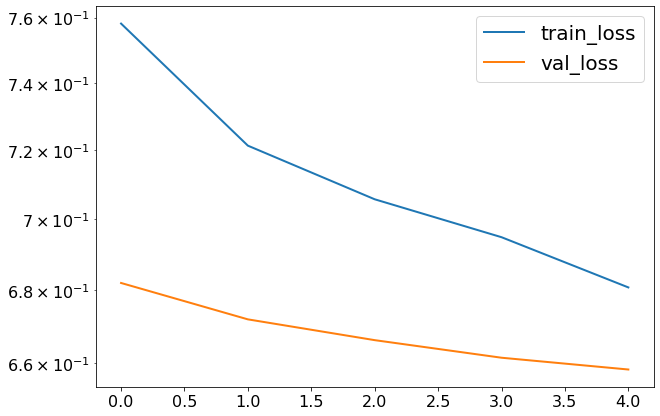

In [9]:
#plot the training loss and the validation loss

plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.yscale('log')
plt.legend()

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0     